## Filtrado de la señal EEG utilizando filtros IIR, FIR y wavelet

#### Importación de librerias

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import signal

#### Abrir archivo txt

In [129]:
f = open("signals/EEG_Toma2_ejercicios.txt")
raw_data = f.readlines()[1] # con f.read() leemos todo el contenido
f.close()

raw_data

'# {"98:D3:81:FD:6D:86": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:81:FD:6D:86", "device connection": "BTH98:D3:81:FD:6D:86", "sampling rate": 100, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-9-29", "time": "10:49:3.17", "channels": [4], "sensor": ["EEGBITREV"], "label": ["A4"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A4"], "special": [{}], "digital IO": [0, 0, 1, 1]}}\n'

In [130]:
x = re.findall("[0-5][0-9]\d", raw_data)

print(x)

['100', '128', '202']


In [131]:
Fs = float(x[0])
Fs = Fs *10
Ts=1/Fs

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


#### Lectura de archivos excluyendo encabezados

In [132]:
SenalEEG = np.genfromtxt("signals/EEG_Toma2_ejercicios.txt", delimiter="\t",skip_header = 3)


#### Visualización de la señal cruda

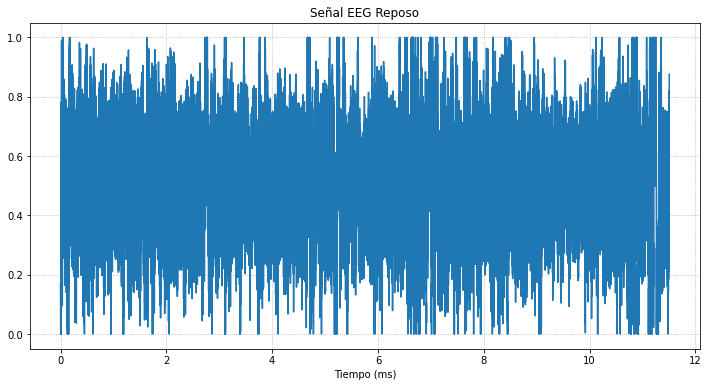

In [145]:
#Conversion a un array
y1 = (SenalEEG[:, 5]) 

#Normalizacion de la señal
y1 = y1  - np.min(y1)
y1 = y1 / np.max(y1)
t1 = (np.arange(0,len(y1)) / Fs)

#Visualizacion de la señal
plt.figure(figsize=(12,6))
plt.plot(t1,y1, label="señal Reposo") 
plt.title("Señal EEG Reposo")    # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("Tiempo (ms)")

fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('SeñalEEG_cruda.png', transparent=False, )
plt.show()


#### Aplicación de filtros

##### Filtro IIR

In [134]:
from scipy.signal import butter, lfilter, lfilter_zi

In [135]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y

#### Filtrado por ondas

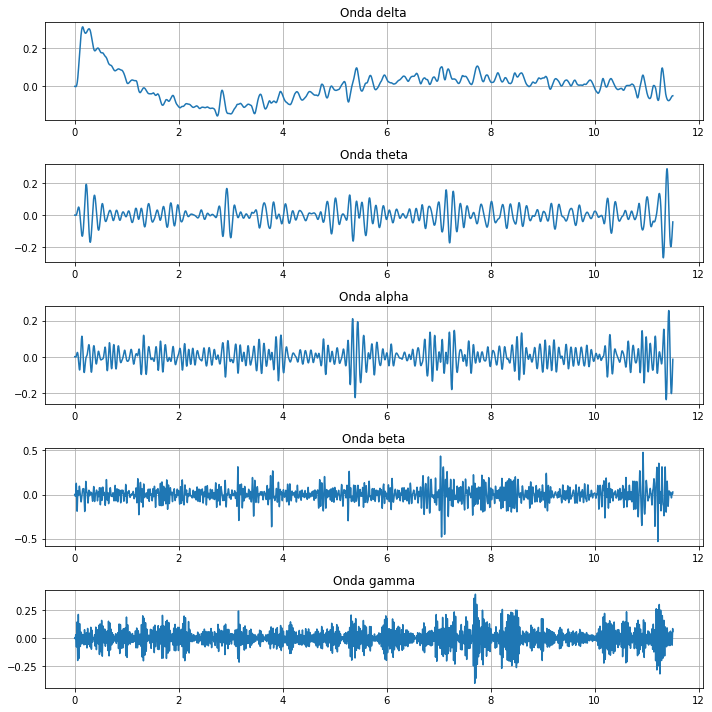

In [146]:
plt.figure(figsize=(10,10))
plt.subplot(511)
plt.subplots_adjust(hspace=0.6, wspace=0.6)

# Filtro por ondas
delta = butter_bandpass_filter(data = y1, lowcut = 0.1, highcut= 4 , fs = Fs, order = 3)
theta = butter_bandpass_filter(data = y1, lowcut = 4, highcut= 8, fs = Fs, order = 3)
alpha = butter_bandpass_filter(data = y1, lowcut = 8, highcut= 13, fs = Fs, order = 3)
beta = butter_bandpass_filter(data = y1, lowcut = 13, highcut= 32, fs = Fs, order = 3)
gamma = butter_bandpass_filter(data = y1, lowcut = 32, highcut= 50, fs = Fs, order = 3)
plt.title("Onda delta")
plt.grid()
plt.plot(t1,delta)

plt.subplot(512)
plt.title("Onda theta")
plt.grid()
plt.plot(t1,theta)

plt.subplot(513)
plt.title("Onda alpha")
plt.grid()
plt.plot(t1,alpha)


plt.subplot(514)
plt.title("Onda beta")
plt.grid()
plt.plot(t1,beta)


plt.subplot(515)
plt.title("Onda gamma")
plt.grid()
plt.plot(t1,gamma)

fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EEG_FiltradoOndas.png', transparent=False, )
plt.tight_layout()
plt.show()

#### Filtro señal en general

In [137]:
def butter_lowpass(freqcut, fs, order=5):
    nyq = 0.5 * fs
    freqcut = freqcut / nyq
    b, a = butter(order, freqcut, 'lowpass')
    return b, a
def butter_lowpass_filter(data, freqcut, fs, order=5):
    b, a = butter_lowpass(freqcut, fs, order=order)
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y

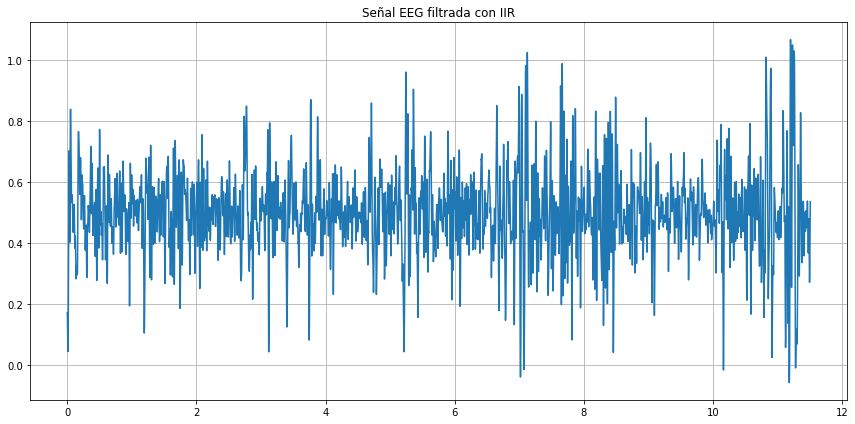

In [147]:

# Filtro por ondas
eeg_filtered = butter_lowpass_filter(data = y1, freqcut = 50, fs = Fs, order = 3)

plt.figure(figsize=(12,6))
plt.title("Señal EEG filtrada con IIR")
plt.grid()
plt.plot(t1,eeg_filtered)
plt.tight_layout()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EEG_FiltroIIR.png', transparent=False, )
plt.show()

##### Aplicacion de filtro FIR

Text(0.5, 15.0, 'Tiempo (s)')

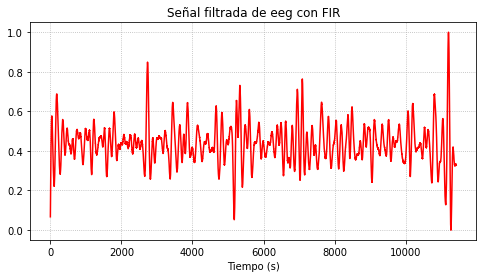

In [148]:
from scipy.signal import firwin, lfilter
wp = 45 *np.pi/(Fs/2)
ws = 55*np.pi/(Fs/2)
dw = abs(wp-ws)
M_FIR = int(8/dw)
wc = (wp+ws )/2 # Frecuencia alta

#Diseño del filtro
w = signal.firwin(numtaps=M_FIR, cutoff=wc, window='hamming', fs=Fs)
w = np.round(w,3)

#Aplicación del filtro
eeg_filtered_fir = signal.lfilter(w,np.array(1),y1)
eeg_filtered_fir = eeg_filtered_fir[80:]
#Normalizacion
eeg_filtered_fir = eeg_filtered_fir  - np.min(eeg_filtered_fir)
eeg_filtered_fir = eeg_filtered_fir / np.max(eeg_filtered_fir)

#Visualizacion
plt.figure(figsize=(8,4))
plt.title('Señal filtrada de eeg con FIR')
plt.plot(eeg_filtered_fir, color="red")
plt.grid(linestyle=":")

fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EEG_FiltroFIR.png', transparent=False, )
plt.xlabel("Tiempo (s)")




##### Aplicacion del filtro utilizando Wavelet

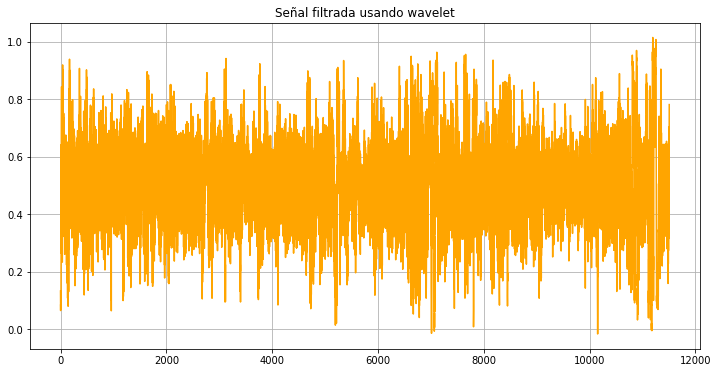

In [149]:
import pywt

coeffs = pywt.wavedec(y1, 'db4', level=10)
umbral = 0.1

# Aplicar el umbral a los coeficientes
coeffs_umbral = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]

# Reconstruir la señal denoised
senal_denoised = pywt.waverec(coeffs_umbral, 'db4')

#Visualizacion
plt.figure(figsize=(12,6))
plt.title('Señal filtrada usando wavelet')
plt.plot(senal_denoised, color="orange")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EEG_FiltroWavelet.png', transparent=False, )
plt.grid()

#### Comparación entre los resultados

##### Visualización de los gráficos

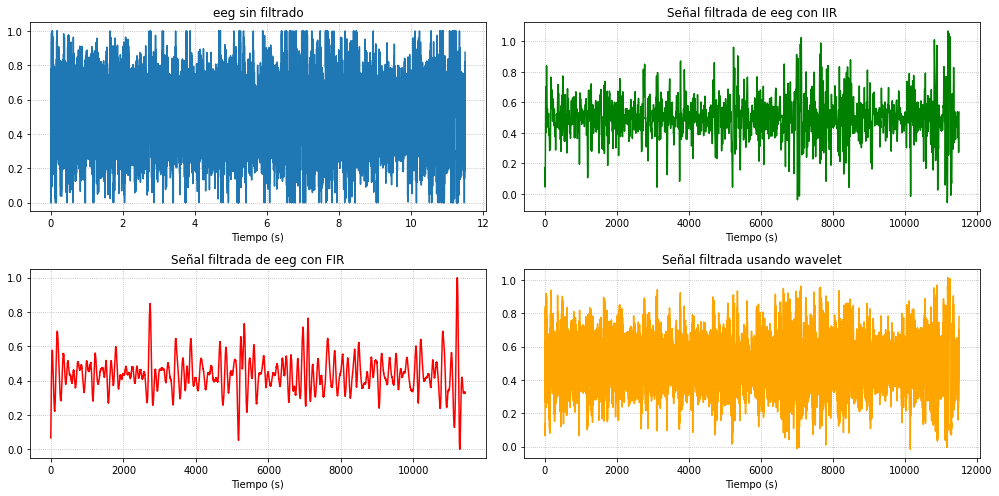

In [150]:
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.subplots_adjust(hspace=0.6,wspace=0.6)

#Ecg crudo
plt.plot(t1, y1)
plt.title("eeg sin filtrado")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg filtrado IIR
plt.subplot(2,2,2)
plt.title('Señal filtrada de eeg con IIR')
plt.plot(eeg_filtered, color ="green")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg filtrado con FIR
plt.subplot(2,2,3)
plt.title('Señal filtrada de eeg con FIR')
plt.plot(eeg_filtered_fir, color="red")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg utilizando wavelets
plt.subplot(2,2,4)
plt.title('Señal filtrada usando wavelet')
plt.plot(senal_denoised, color="orange")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.tight_layout()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ComparisonEEG.png', transparent=False, )
plt.show()

##### Respuesta en frecuencia de las señales filtradas

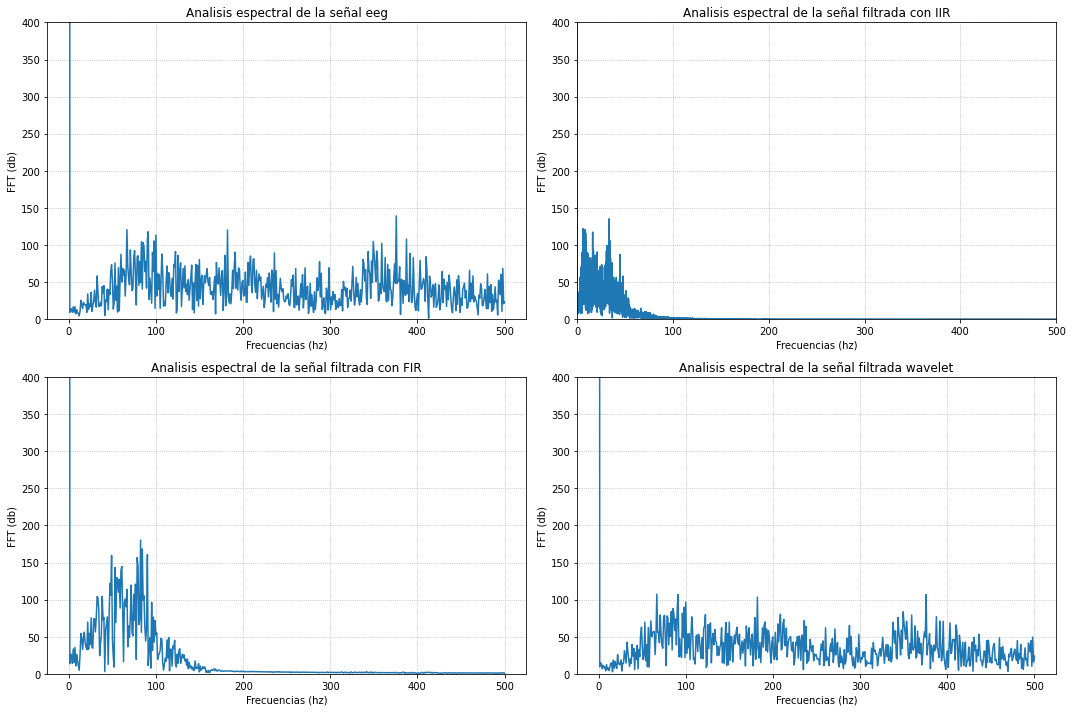

In [151]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.subplots_adjust(hspace=0.6,wspace=0.6)

# señal sin procesar
N = 2 ** 10 # Resolución del bitalino
X = np.fft.fft(y1)
X = X[0:N//2]
X = np.abs(X)
F = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,1)
plt.plot(F, X)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal eeg")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.ylim(0,400)

# Filtrado con IIR
N1 = len(eeg_filtered)
X1 = np.fft.fft(eeg_filtered)
X1 = np.abs(X1)
F1 = (Fs)*(np.arange(1,N1+1)/N1)
plt.subplot(2,2,2)
plt.plot(F1, X1)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada con IIR")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.ylim(0,400)
plt.xlim((0, Fs/2))



# filtrado con FIR
X2 = np.fft.fft(eeg_filtered_fir)
X2 = X2[0:N//2]
X2 = np.abs(X2)
F2 = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,3)
plt.plot(F2, X2)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada con FIR")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.ylim(0,400)

# Filtrado con wavelet
X3 = np.fft.fft(senal_denoised)
X3 = X3[0:N//2]
X3 = np.abs(X3)
F3 = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,4)
plt.plot(F3, X3)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada wavelet")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.ylim(0,400)

fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('FrecuenciasEEG.png', transparent=False, )
plt.tight_layout()
plt.show()